<a href="https://colab.research.google.com/github/sumitsaxena-git/ai-bootcamp/blob/main/D3_Advanced_RAG_Techniques_Modern_AI_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modern AI Pro: Advanced RAG with LLMs
The reasons why we need to use RAG:
Problems that RAGs try to solve in LLMs

1. Hallucination — wrong generation with high confidence
2. Attribution — where does the information come from
3. Staleness — cut off date
4. Revisions — remove or revise information in the corpus
5. Customization — make it work in your own state

## Step 1: Load the data
Building on top of this earlier [class](https://colab.research.google.com/drive/1BatABgfZpBdj1gIj6YVAs4ZuSOi2P9tr#scrollTo=Ejlt8qDLfoYV).

In [ ]:
!pip  install -U -q openai chromadb pypdf2 langchain sentence_transformers tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import urllib.request
import PyPDF2
import io

franklin_10k = 'https://s201.q4cdn.com/562074409/files/doc_financials/2023/ar/Franklin-Resources-2023-Annual_10-K.pdf'
req = urllib.request.Request(franklin_10k, headers={'User-Agent' : "Magic Browser"})
remote_file = urllib.request.urlopen(req).read()
remote_file_bytes = io.BytesIO(remote_file)
reader = PyPDF2.PdfReader(remote_file_bytes)
pdf_texts = [p.extract_text().strip() for p in reader.pages]
pdf_texts = [text for text in pdf_texts if text]

In [ ]:
pdf_texts

['One Franklin Parkway, San Mateo, CA 94403-1906   \nfranklinresources.comUS_COR_1826458_1726458  \nFRI A23 12/23\nOur investment teams\nFranklin Templeton brings together a wide range of \ninvestment brands and teams to provide our clients \ndeep expertise within and across asset classes,  \ninvestment styles and geographies. Our unique business \nmodel combines the benefits of global strength with  \nthe specialization of autonomous investment teams \neach with differentiated investment philosophies.\nBenefit Street Partners\nBrandywine Global\nClarion Partners\nClearBridge Investments\nFiduciary Trust  International\nFranklin Equity Group\nFranklin Income Investors\nFranklin Mutual Series\nFranklin Templeton   \nFixed Income\nFranklin Templeton  \n Global Private Equity\nFranklin Templeton \n Investment SolutionsK2 Advisors\nLexington Partners\nMartin Currie\nO’Shaughnessy   \nAsset Management\nRoyc e Investment   \nPartners\nTempleton  Global \nInvestments\nTempleton   \nGlobal Mac

In [ ]:
# Utils:
def word_wrap(string, n_chars=128):
    # Wrap a string at the next space after n_chars
    if len(string) < n_chars:
        return string
    else:
        return string[:n_chars].rsplit(' ', 1)[0] + '\n' + word_wrap(string[len(string[:n_chars].rsplit(' ', 1)[0])+1:], n_chars)

word_wrap(pdf_texts[1])

'f FRANKLIN RESOURCES, INC. ANNU AL REPORT 2023\nImportant Information Regarding Forward-Looking Statements and Non-GAAP\nFinancial Information\nThis report contains forward-looking statements that are provided under the “safe harbor” protection of\nthe Private Securities Litigation Reform Act of 1995  \nand involve a number of known and unknown risks, uncertainties and other\nimportant factors. You should read the discussions under the headings “Forward- \nLooking Statements” and “Risk Factors” in Part\nI of our Annual Report on Form 10-K for our fiscal year ended September 30, 2023 (“Form 10-K”) for important \ninformation\nconcerning such matters. This report also contains non-GAAP financial measures such as adjusted operating revenues, adjusted\noperating income, \nadjusted operating margin, adjusted net income and adjusted diluted earnings per share, which are not\nsubstitutes for measures calculated in accordance with \nU.S. GAAP. You should read the “Supplemental Non-GAAP Financ

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=20
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(word_wrap(character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

Firms with a broader suite of investment 
capabilities that offer value beyond investing 
will be partners of choice. As
expectations 
increase for value-added services, we believe 
we are well-positioned in the long term  
due to the breadth and
depth of our 
investment capabilities, technology,  
content and capital resources.
One of our strategic priorities has been to

increase our scale in key segments of the 
industry that reflect client demand, including 
the insurance and retirement
sectors. We 
believe our differentiated model of preserving 
the investment autonomy of our specialist 
investment managers,
supported by the 
resources of a global firm, is unrivaled in the 
industry and should produce strong positive 
long-term
results.DO NOT
USE

Total chunks: 517


In [ ]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[0]))
print(f"\nTotal chunks: {len(token_split_texts)}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

one franklin parkway, san mateo, ca 94403 - 1906 franklinresources. comus _ cor _ 1826458 _ 1726458 fri a23 12 / 23 our
investment teams franklin templeton brings together a wide range of investment brands and teams to provide our clients deep
expertise within and across asset classes, investment styles and geographies. our unique business model combines the benefits
of global strength with the specialization of autonomous investment teams each with differentiated investment philosophies.
benefit street partners brandywine global clarion partners clearbridge investments fiduciary trust international franklin
equity group franklin income investors franklin mutual series franklin templeton fixed income franklin templeton global private
equity franklin templeton investment solutionsk2 advisors lexington partners martin currie o ’ shaughnessy asset management
royc e investment partners templeton global investments templeton global macro western asset

Total chunks: 636


In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[0.03894916549324989, -0.0020960636902600527, -0.033266857266426086, -0.026648493483662605, -0.04062505438923836, 0.04738006740808487, 0.09456481039524078, 0.03225749358534813, 0.0175265371799469, -0.011090502142906189, 0.0030730832368135452, 0.0989290103316307, 0.0712689533829689, 0.06265274435281754, 0.030726730823516846, -0.06190256029367447, 0.006557270418852568, -0.03307168558239937, -0.06917520612478256, 0.033160530030727386, -0.08158610016107559, -0.08951772749423981, -0.05030355975031853, 0.021742917597293854, 0.03398590907454491, -0.10059506446123123, 0.05965336412191391, 0.03782707452774048, -0.03807995840907097, -0.022058427333831787, -0.0021607365924865007, 0.04707640781998634, 0.015131481923162937, -0.015733974054455757, -0.016919054090976715, 0.07186946272850037, -0.10077625513076782, -0.04516224190592766, 0.017922107130289078, 0.01171806175261736, 0.019053790718317032, -0.030212003737688065, -0.03159177303314209, 0.017255235463380814, 0.0042288112454116344, -0.076665244

In [ ]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("ft_annual_report", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

636

## Step 2: Visualize the query.

In [ ]:
!pip install umap-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
import umap
from tqdm import tqdm #Progress bar for python
import numpy as np
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [ ]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
import matplotlib.pyplot as plt

def visualize_results(query, projected_query_embedding, projected_retrieved_embeddings):
  plt.figure()
  plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
  plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
  plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

  plt.gca().set_aspect('equal', 'datalim')
  plt.title(f'{query}')
  plt.axis('off')

def analyze_query(query):
  results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])
  retrieved_documents = results['documents'][0]

  for document in results['documents'][0]:
    print(word_wrap(document),"\n")

  projected_retrieved_embeddings = project_embeddings(results['embeddings'][0], umap_transform)
  query_embedding = embedding_function([query])[0]

  projected_query_embedding = project_embeddings([query_embedding], umap_transform)

  visualize_results(query, projected_query_embedding, projected_retrieved_embeddings)



continued contributions of these people. global and / or local laws and regulations could impose restrictions on compensation
paid by financial institutions, which could restrict our ability to compete effectively for qualified professionals. as our
business develops, we may need to increase the number of individuals that we employ. moreover, in order to retain certain key
personnel, we may be required to increase compensation to such individuals and increase our key management succession planning,
resulting in additional expense without a corresponding increase in potential revenues. there is no assurance that we will be
successful in finding, attracting and retaining qualified individuals, and the departure of key investment personnel, in
particular, could cause us to lose clients, which could have a material adverse effect on our financial condition, results of
operations and business prospects. in addition, due to the global nature of our business, our 

subsidiaries are determined

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


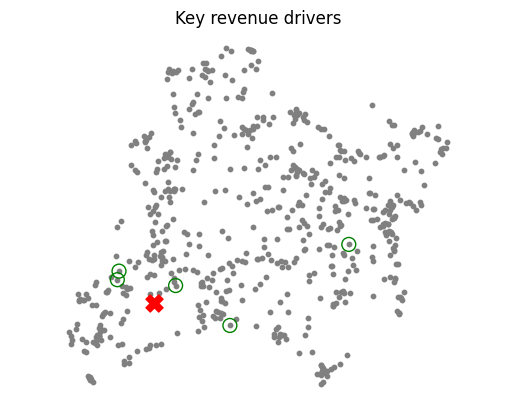

In [ ]:
#Trying a general query
query = "Key revenue drivers"
analyze_query(query)

## Step 3: Augment the query

In [ ]:
from google.colab import userdata

!pip install git+https://gitlab.com/gauthammsam/mitrallm.git --quiet
from mitrallm import MitraLLM
llm = MitraLLM(
    token     = userdata.get("MITRA_TOKEN"),
    accessapi = userdata.get("MITRA_ENDPOINT")
)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 7.9 MB/s eta 0:00:00


In [ ]:
def rag_query(query):
  results = chroma_collection.query(query_texts=[query], n_results=5)
  retrieved_documents = results['documents'][0]
  information = "\n\n".join(retrieved_documents)
  return llm.invoke(f"Question: {query}. \n Information: {information}")

rag_query(query)

'Based on the information provided, key revenue drivers for the business include:\n\n1.'

In [ ]:
def augment_query_generated(query):
  augmented_query = f"Provide an example answer to the given question, that might be found in a document like an annual report. The question is: {query}"
  #print(augmented_query)
  return llm.invoke(augmented_query)

augmented_query = augment_query_generated(query)

In [ ]:
join_query = f"{query}{augmented_query}"
print(word_wrap(join_query))

Key revenue driversHere is an example response to the question "Key revenue drivers" that could be found in an organization's
annual report:

"In the fiscal year 2022, our company experienced significant growth in revenue, largely attributable to
several key drivers.

1. **Product Innovation**: Our continued commitment to research and development has led to the launch of
several new and improved products that better meet our customers' needs. New product features, enhanced quality, and additional
service offerings have allowed us to capture a larger market share and increase sales volume.

2. **Strategic Acquisitions**:
This year, we successfully acquired ABC Technologies, which has not only expanded our technological capabilities but has also
brought in a lucrative customer base. The integration of their products into our portfolio has allowed us to drive revenue
synergies and penetrate new markets.

3. **Market Expansion**: Our strategic initiative to expand into emerging markets has

In [ ]:
def augmented_rag(query):
  aug_query = augment_query_generated(query)
  join_query = f"{query}{augmented_query}"
  return rag_query(join_query)

In [ ]:
augmented_rag(join_query)

"It seems that you've provided some details that suggest how a company's revenue and operations are influenced by numerous factors, some of which are outlined in the list of key revenue drivers and further elaborated upon in the additional context. These factors include market conditions, strategic choices such as acquisitions, and the ways the company adapts to industry changes and competition. The nuances of these operational aspects highlight the complexity of managing and growing an asset management business, particularly in volatile markets. \n\nTo summarize, the key revenue drivers and insights from the additional context, it's clear that the company's revenue is influenced by:\n\n1. Product and service offerings, innovation, and quality.\n2. Strategic acquisitions that provide new capabilities and customer bases.\n3. Expansion into new markets with localized offerings.\n4. Competitive and adaptable pricing strategies.\n5. Customer retention, upselling, and cross-selling tactics.

100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


(-0.015517006814479872,
 9.225584428012372,
 -0.5868785597383976,
 7.644786960631609)

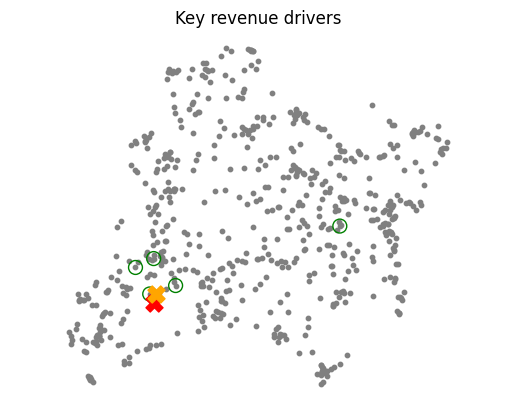

In [ ]:
results = chroma_collection.query(query_texts=join_query, n_results=5, include=['documents', 'embeddings'])
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([query])
augmented_query_embedding = embedding_function([join_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

## Step 4: Using cross encode models for ranking


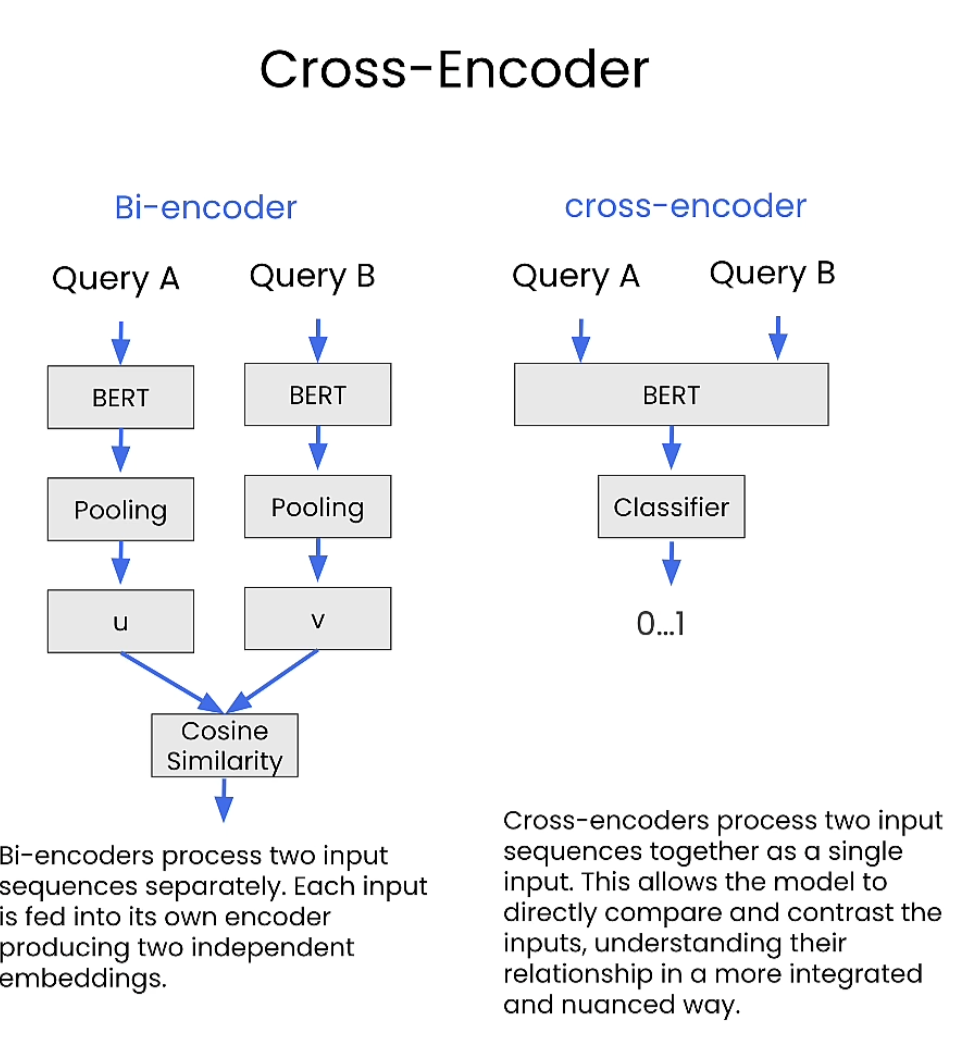

In [ ]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def compute_ranking(query):
  results = chroma_collection.query(query_texts=[query], n_results=20)
  retrieved_documents = results['documents'][0]
  pairs = [[query, doc] for doc in retrieved_documents]
  scores = cross_encoder.predict(pairs)

  sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]

  print("Scores and New Ordering:")
  for rank, index in enumerate(sorted_indices, start=1):
      print(f"Score: {scores[index]}, New Order: {rank}")

  top_documents = [retrieved_documents[i] for i in sorted_indices]
  top_documents_joined = " ".join(top_documents)
  print("Combined Top 5 Documents:", top_documents_joined)

  return top_documents_joined


query = f"Who are the key executives of Franklin Templeton?"
top_docs = compute_ranking(query)
print(word_wrap(top_docs))

Scores and New Ordering:
Score: 5.666338920593262, New Order: 1
Score: 5.223696231842041, New Order: 2
Score: 4.708074569702148, New Order: 3
Score: 4.6262407302856445, New Order: 4
Score: 3.922945976257324, New Order: 5
Combined Top 5 Documents: templeton ’ s financial flexibility and promote matthew nicholls executive vice president chief financial officer chief operating officerdiversification and discipline benefit shareholders and clients our continuing investments in the business, while protecting our financial position in the context of challenging market conditions. great - west lifeco will make an initial incremental long - term asset allocation of $ 25 billion to our specialist investment manager s and become a long - term shareholder in franklin resources. the agreement furthers our goal of growing insur ance client assets and expands the existing relationship between franklin templeton and the power group of companies in the key areas of retirement, asset management and wea

In [ ]:
new_query = f"Answer this specific Question: {query} from the source documents: {top_docs}"
print(llm.invoke(new_query))

Based on the information provided, the key executives of Franklin Resources, Inc. (also known as Franklin Templeton) mentioned include:

1. Jennifer M. Johnson - President and Chief Executive Officer
2. Matthew Nicholls - Executive Vice President, Chief Financial Officer, and Chief Operating Officer
3. Alok Sethi - Executive Vice President and Head of Global Operations
4. Gwen L. Shaneyfelt - Chief Accounting Officer
5. Adam B. Spector - Executive Vice President and Head of Global Distribution

Additionally, there are other notable individuals listed who might not necessarily be categorized as key executives, but hold significant positions within the organization:

- Selene Oh - Chief Communications Officer
- Jennifer Ball - Chief Marketing Officer
- Adam Petryk, CFA - Head of Franklin Templeton Investment Solutions
- Brett Goldstein, CFA - Co-Chief Investment Officer of Putnam Global Asset Allocation
- Wylie Tollette, CFA - Chief Investment Officer of Franklin Templeton Investment Sol

In [ ]:
print(augmented_rag(query))

Provide an example answer to the given question, that might be found in a document like an annual report. The question is: Who are the key executives of Franklin Templeton?
The key executives of Franklin Templeton, as mentioned in the text, include:

1. Jennifer M. Johnson - President and Chief Executive Officer (CEO)
2. Selene Oh - Chief Communications Officer
3. Jennifer Ball - Chief Marketing Officer
4. Adam Petryk, CFA - Head of Franklin Templeton Investment Solutions
5. Brett Goldstein, CFA - Co-Chief Investment Officer, Putnam Global Asset Allocation
6. Wylie Tollette, CFA - Chief Investment Officer, Franklin Templeton Investment Solutions
7. Robert Schoen - Co-Chief Investment Officer, Putnam Global Asset Allocation

The text highlights the company's strategic evolution, key acquisitions, innovative partnerships, and various initiatives that have contributed to its revenue growth, such as product diversification, market expansion, strategic partnerships, competitive pricing stra

In [ ]:
print(rag_query(query))

The key executives of Franklin Resources, Inc., which operates as Franklin Templeton, mentioned in the provided information are:

1. Jennifer M. Johnson - President and Chief Executive Officer of Franklin Resources, Inc.
2. Matthew Nicholls - Executive Vice President, Chief Financial Officer, and Chief Operating Officer
3. Selene Oh - Chief Communications Officer
4. Jennifer Ball - Chief Marketing Officer
5. Adam Petryk, CFA - Head of Franklin Templeton Investment Solutions
6. Brett Goldstein, CFA - Co-Chief Investment Officer at Putnam Global Asset Allocation
7. Wylie Tollette, CFA - Chief Investment Officer at Franklin Templeton Investment Solutions
8. Robert Schoen - Co-Chief Investment Officer at Putnam Global Asset Allocation

These executives help guide the strategic direction of the firm, manage its investment solutions, oversee financial operations, communications, and marketing, and contribute to the company’s overall leadership.
